<a href="https://colab.research.google.com/github/GioAcosta1/Proyecto_Final_Cancer_de_Piel/blob/main/DETECCION_Y_CLASIFICACION_DE_CANCER_DE_PIEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Montaje de drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Ordenamiento de las imágenes**

In [ ]:
#Código que solo se ejecuta una vez

#Descomprimir base de datos de imágenes
import io
import zipfile
import os
import glob


!unzip "/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/classes.zip" -d "/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/classes"

In [ ]:
#Librerias a utilizar
import pandas as pd
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from PIL import Image

from keras.utils.np_utils import to_categorical
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.metrics import confusion_matrix

In [ ]:
#Lectura de metadata

data_skin = pd.read_csv('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM10000_metadata.csv')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


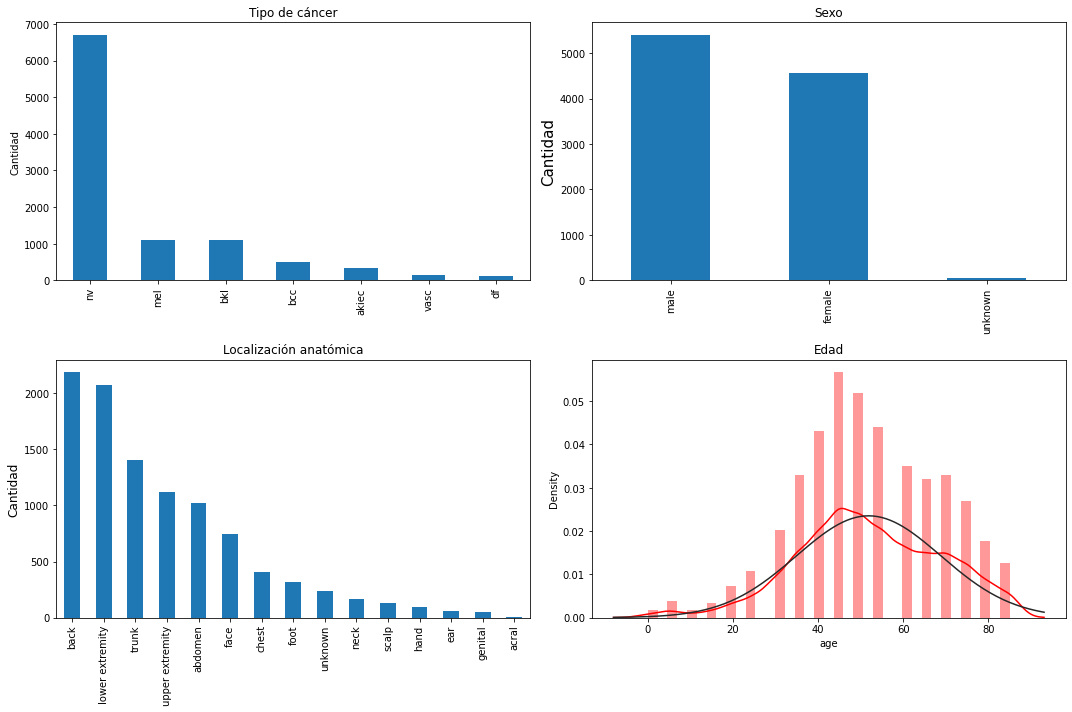

In [ ]:
#Ver la distribución de los datos
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
data_skin['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Cantidad')
ax1.set_title('Tipo de cáncer');

ax2 = fig.add_subplot(222)
data_skin['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Cantidad', size=15)
ax2.set_title('Sexo');

ax3 = fig.add_subplot(223)
data_skin['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Cantidad',size=12)
ax3.set_title('Localización anatómica')

ax4 = fig.add_subplot(224)
sample_age = data_skin[pd.notnull(data_skin['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Edad')

plt.tight_layout()
plt.show()

In [ ]:
#Etiquetado

l_encode = LabelEncoder()
l_encode.fit(data_skin['dx'])
LabelEncoder()
print(list(l_encode.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
data_skin['label'] = l_encode.transform(data_skin['dx'])
print(data_skin.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
5978  HAM_0005081  ISIC_0029326   nv  follow_up  30.0    male   
2809  HAM_0002083  ISIC_0024432  bcc      histo  65.0    male   
6608  HAM_0006530  ISIC_0029686   nv  follow_up  50.0    male   
2957  HAM_0000807  ISIC_0032164  bcc      histo  65.0  female   
1199  HAM_0002848  ISIC_0027598   df  consensus  60.0  female   
6887  HAM_0006389  ISIC_0027738   nv      histo  70.0    male   
7117  HAM_0006516  ISIC_0033846   nv      histo  35.0  female   
4422  HAM_0002635  ISIC_0029364   nv  follow_up  70.0    male   
2678  HAM_0003373  ISIC_0031450  bcc      histo  65.0    male   
7604  HAM_0003193  ISIC_0032818   nv      histo  35.0  female   

         localization  label  
5978          abdomen      5  
2809             face      1  
6608          abdomen      5  
2957            chest      1  
1199  lower extremity      3  
6887             back      5  
7117            trunk      5  
4422  lower extremity      5  
2678 

In [ ]:
print(data_skin['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [ ]:
limite = min(data_skin['dx'].value_counts())
limite

115

In [ ]:
df_type_0 = data_skin[data_skin['dx']=='akiec']#[0:limite]
df_type_1 = data_skin[data_skin['dx']=='bcc']#[0:limite]
df_type_2 = data_skin[data_skin['dx']=='bkl']#[0:limite]
df_type_3 = data_skin[data_skin['dx']=='df']#[0:limite]
df_type_4 = data_skin[data_skin['dx']=='mel']#[0:limite]
df_type_5 = data_skin[data_skin['dx']=='nv']#[0:limite]
df_type_6 = data_skin[data_skin['dx']=='vasc']#[0:limite]

len(df_type_0)

327

In [ ]:
#Balancear base de datos

from sklearn.utils import resample

#df_type_0_bal = resample(df_type_0, replace=True, n_samples = 115, random_state=42)
#df_type_1_bal = resample(df_type_1, replace=True, n_samples = 115, random_state=42)
#df_type_2_bal = resample(df_type_2, replace=True, n_samples = 115, random_state=42)
#df_type_3_bal = resample(df_type_3, replace=True, n_samples = 115, random_state=42)
#df_type_4_bal = resample(df_type_4, replace=True, n_samples = 115, random_state=42)
#df_type_5_bal = resample(df_type_5, replace=True, n_samples = 115, random_state=42)
#df_type_6_bal = resample(df_type_6, replace=True, n_samples = 115, random_state=42)

data_skin_bal = pd.concat([df_type_0, df_type_1, df_type_2,
                           df_type_3, df_type_4, df_type_5,
                           df_type_6])

print(data_skin_bal['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [ ]:
#Código que solo se ejecuta una sola vez
import glob
image_path = glob.glob('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_ORGANIZED/classes/**/*.jpg')

In [ ]:
#Código que solo se ejecuta una sola vez
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/akiec/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/bcc/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/bkl/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/df/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/mel/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/nv/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/vasc/')

In [ ]:
#Código que se ejecuta una sola vez
registro_id = []
for id in data_skin_bal['image_id']:
  registro_id.append(id)
  find_path = [s for s in image_path if id in s]
  for path in find_path:
    p = path.split('/')
    if 'akiec' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/akiec/')
    elif 'bcc' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/bcc/')
    elif 'bkl' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/bkl/')
    elif 'df' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/df/')
    elif 'mel' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/mel/')
    elif 'nv' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/nv/')
    elif 'vasc' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/vasc/') 



In [ ]:
arc_akiec = os.listdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/nv/')
len(arc_akiec)

6705

# **Creación de Data Generator**

In [ ]:
data_generator = ImageDataGenerator(rescale = 1.0/255.0,validation_split = 0.15)

In [ ]:
path_classes = '/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/'
train_image_generator = data_generator.flow_from_directory(
    directory = path_classes,
    class_mode = 'categorical',
    batch_size = 32,
    target_size = (64,64),
    subset = 'training'
)
val_image_generator = data_generator.flow_from_directory(
    directory = path_classes,
    class_mode = 'categorical',
    batch_size = 32,
    target_size = (64, 64),
    subset = 'validation'
)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.


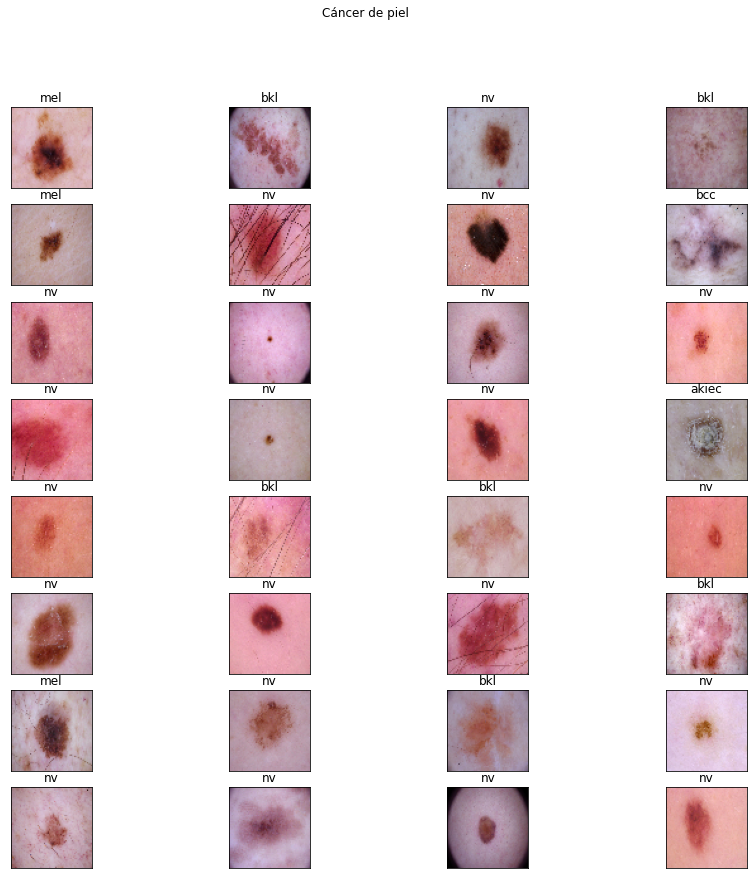

In [ ]:
x, y = next(train_image_generator)
classes = train_image_generator.class_indices
fig = plt.figure(figsize=(15,14))
fig.suptitle('Cáncer de piel')
for i in range(0, 32):
  image = x[i]
  y_search = y[i,:]
  idx = list(np.where(y_search==1))
  n_type = list(classes.keys())[list(classes.values()).index(idx[0])]
  fig.add_subplot(8,4,i+1)
  plt.imshow(image,cmap='gray')
  plt.title(n_type)
  plt.xticks([])
  plt.yticks([])
  n_type = ''

# **Definición de red neuronal convolucional**

In [ ]:
n_classes = 7

modelo = Sequential()
modelo.add(Conv2D(256, (3,3), activation='relu', input_shape=(64,64,3)))
modelo.add(MaxPool2D(pool_size=(2,2,)))
modelo.add(Dropout(0.3))

modelo.add(Conv2D(128, (3,3), activation='relu'))
modelo.add(MaxPool2D(pool_size=(2,2,)))
modelo.add(Dropout(0.3))

modelo.add(Conv2D(64, (3,3), activation='relu'))
modelo.add(MaxPool2D(pool_size=(2,2,)))
modelo.add(Dropout(0.3))
modelo.add(Flatten())

modelo.add(Dense(32))
modelo.add(Dense(7, activation = 'softmax'))
modelo.summary()

modelo.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0

# **Entrenamiento de la red neuronal convolucional**

In [ ]:
num_epochs = 10
historial = modelo.fit(
    train_image_generator,
    steps_per_epoch = train_image_generator.samples//train_image_generator.batch_size,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples // val_image_generator.batch_size,
    epochs = num_epochs)
modelo.save('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/10_epochs_cancer.h5')

Epoch 1/10
266/266 [==============================] - 4806s 18s/step - loss: 1.0442 - acc: 0.6691 - val_loss: 0.9299 - val_acc: 0.6685
Epoch 2/10
266/266 [==============================] - 110s 413ms/step - loss: 0.9568 - acc: 0.6727 - val_loss: 0.9066 - val_acc: 0.6793
Epoch 3/10
266/266 [==============================] - 105s 394ms/step - loss: 0.9224 - acc: 0.6743 - val_loss: 0.8957 - val_acc: 0.6936
Epoch 4/10
266/266 [==============================] - 106s 398ms/step - loss: 0.8890 - acc: 0.6848 - val_loss: 0.8660 - val_acc: 0.7004
Epoch 5/10
266/266 [==============================] - 104s 393ms/step - loss: 0.8562 - acc: 0.6891 - val_loss: 0.7756 - val_acc: 0.7126
Epoch 6/10
266/266 [==============================] - 105s 395ms/step - loss: 0.8166 - acc: 0.6990 - val_loss: 0.7575 - val_acc: 0.7167
Epoch 7/10
266/266 [==============================] - 104s 391ms/step - loss: 0.8021 - acc: 0.7037 - val_loss: 0.7466 - val_acc: 0.7228
Epoch 8/10
266/266 [=============================

In [ ]:
num_epochs = 10
historial_2 = modelo.fit(
    train_image_generator,
    steps_per_epoch = train_image_generator.samples//train_image_generator.batch_size,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples // val_image_generator.batch_size,
    epochs = num_epochs)
modelo.save('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/20_epochs_cancer.h5')

Epoch 1/10
266/266 [==============================] - 105s 394ms/step - loss: 0.7303 - acc: 0.7281 - val_loss: 0.7145 - val_acc: 0.7432
Epoch 2/10
266/266 [==============================] - 104s 390ms/step - loss: 0.7109 - acc: 0.7353 - val_loss: 0.7228 - val_acc: 0.7486
Epoch 3/10
266/266 [==============================] - 104s 390ms/step - loss: 0.7104 - acc: 0.7346 - val_loss: 0.6859 - val_acc: 0.7425
Epoch 4/10
266/266 [==============================] - 104s 392ms/step - loss: 0.6932 - acc: 0.7439 - val_loss: 0.6924 - val_acc: 0.7609
Epoch 5/10
266/266 [==============================] - 103s 388ms/step - loss: 0.6853 - acc: 0.7475 - val_loss: 0.6999 - val_acc: 0.7459
Epoch 6/10
266/266 [==============================] - 103s 388ms/step - loss: 0.6782 - acc: 0.7479 - val_loss: 0.6531 - val_acc: 0.7690
Epoch 7/10
266/266 [==============================] - 105s 393ms/step - loss: 0.6659 - acc: 0.7529 - val_loss: 0.6764 - val_acc: 0.7582
Epoch 8/10
266/266 [============================

In [ ]:
num_epochs = 10
historial_3 = modelo.fit(
    train_image_generator,
    steps_per_epoch = train_image_generator.samples//train_image_generator.batch_size,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples // val_image_generator.batch_size,
    epochs = num_epochs)
modelo.save('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/30_epochs_cancer.h5')

Epoch 1/10
266/266 [==============================] - 103s 386ms/step - loss: 0.6385 - acc: 0.7633 - val_loss: 0.6661 - val_acc: 0.7554
Epoch 2/10
266/266 [==============================] - 102s 385ms/step - loss: 0.6089 - acc: 0.7740 - val_loss: 0.6493 - val_acc: 0.7697
Epoch 3/10
266/266 [==============================] - 104s 391ms/step - loss: 0.6129 - acc: 0.7729 - val_loss: 0.6452 - val_acc: 0.7683
Epoch 4/10
266/266 [==============================] - 100s 378ms/step - loss: 0.6033 - acc: 0.7729 - val_loss: 0.6688 - val_acc: 0.7609
Epoch 5/10
266/266 [==============================] - 100s 375ms/step - loss: 0.6122 - acc: 0.7712 - val_loss: 0.7206 - val_acc: 0.7418
Epoch 6/10
266/266 [==============================] - 100s 374ms/step - loss: 0.5906 - acc: 0.7839 - val_loss: 0.6339 - val_acc: 0.7595
Epoch 7/10
266/266 [==============================] - 99s 372ms/step - loss: 0.5872 - acc: 0.7806 - val_loss: 0.6550 - val_acc: 0.7683
Epoch 8/10
266/266 [=============================

In [ ]:
num_epochs = 10
historial_4 = modelo.fit(
    train_image_generator,
    steps_per_epoch = train_image_generator.samples//train_image_generator.batch_size,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples // val_image_generator.batch_size,
    epochs = num_epochs)
modelo.save('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/40_epochs_cancer.h5')

Epoch 1/10
266/266 [==============================] - 122s 459ms/step - loss: 0.5566 - acc: 0.7938 - val_loss: 0.6809 - val_acc: 0.7493
Epoch 2/10
266/266 [==============================] - 105s 393ms/step - loss: 0.5511 - acc: 0.7934 - val_loss: 0.6663 - val_acc: 0.7452
Epoch 3/10
266/266 [==============================] - 100s 377ms/step - loss: 0.5525 - acc: 0.7898 - val_loss: 0.6461 - val_acc: 0.7711
Epoch 4/10
266/266 [==============================] - 99s 373ms/step - loss: 0.5408 - acc: 0.7979 - val_loss: 0.6282 - val_acc: 0.7711
Epoch 5/10
266/266 [==============================] - 100s 376ms/step - loss: 0.5441 - acc: 0.7964 - val_loss: 0.6487 - val_acc: 0.7677
Epoch 6/10
266/266 [==============================] - 100s 374ms/step - loss: 0.5313 - acc: 0.8025 - val_loss: 0.6319 - val_acc: 0.7683
Epoch 7/10
266/266 [==============================] - 100s 376ms/step - loss: 0.5358 - acc: 0.8020 - val_loss: 0.6774 - val_acc: 0.7425
Epoch 8/10
266/266 [=============================

In [ ]:
num_epochs = 10
historial_5 = modelo.fit(
    train_image_generator,
    steps_per_epoch = train_image_generator.samples//train_image_generator.batch_size,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples // val_image_generator.batch_size,
    epochs = num_epochs)
modelo.save('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/50_epochs_cancer.h5')

Epoch 1/10
266/266 [==============================] - 100s 374ms/step - loss: 0.5119 - acc: 0.8079 - val_loss: 0.6366 - val_acc: 0.7656
Epoch 2/10
266/266 [==============================] - 99s 373ms/step - loss: 0.5054 - acc: 0.8087 - val_loss: 0.6354 - val_acc: 0.7697
Epoch 3/10
266/266 [==============================] - 99s 371ms/step - loss: 0.5022 - acc: 0.8126 - val_loss: 0.6463 - val_acc: 0.7636
Epoch 4/10
266/266 [==============================] - 99s 370ms/step - loss: 0.4945 - acc: 0.8157 - val_loss: 0.6558 - val_acc: 0.7615
Epoch 5/10
266/266 [==============================] - 99s 373ms/step - loss: 0.5123 - acc: 0.8062 - val_loss: 0.6486 - val_acc: 0.7697
Epoch 6/10
266/266 [==============================] - 99s 371ms/step - loss: 0.4943 - acc: 0.8134 - val_loss: 0.6524 - val_acc: 0.7717
Epoch 7/10
266/266 [==============================] - 99s 375ms/step - loss: 0.4917 - acc: 0.8159 - val_loss: 0.6351 - val_acc: 0.7629
Epoch 8/10
266/266 [==============================] - 

In [ ]:
modelo_actual = load_model('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/50_epochs_cancer.h5')

In [ ]:
num_epochs = 10
historial_6 = modelo_actual.fit(
    train_image_generator,
    steps_per_epoch = train_image_generator.samples//train_image_generator.batch_size,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples // val_image_generator.batch_size,
    epochs = num_epochs)


Epoch 1/10
266/266 [==============================] - 4395s 16s/step - loss: 0.4674 - acc: 0.8260 - val_loss: 0.6651 - val_acc: 0.7670
Epoch 2/10
266/266 [==============================] - 110s 415ms/step - loss: 0.4765 - acc: 0.8204 - val_loss: 0.6638 - val_acc: 0.7554
Epoch 3/10
266/266 [==============================] - 107s 403ms/step - loss: 0.4785 - acc: 0.8192 - val_loss: 0.6416 - val_acc: 0.7738
Epoch 4/10
266/266 [==============================] - 107s 401ms/step - loss: 0.4606 - acc: 0.8228 - val_loss: 0.6644 - val_acc: 0.7704
Epoch 5/10
266/266 [==============================] - 107s 401ms/step - loss: 0.4588 - acc: 0.8277 - val_loss: 0.6896 - val_acc: 0.7615
Epoch 6/10
266/266 [==============================] - 106s 399ms/step - loss: 0.4647 - acc: 0.8237 - val_loss: 0.6738 - val_acc: 0.7568
Epoch 7/10
266/266 [==============================] - 106s 397ms/step - loss: 0.4611 - acc: 0.8266 - val_loss: 0.7121 - val_acc: 0.7554
Epoch 8/10
266/266 [=============================

NameError: ignored

In [ ]:
modelo_actual.save('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/60_epochs_cancer.h5')

In [ ]:
num_epochs = 10
historial_7 = modelo_actual.fit(
    train_image_generator,
    steps_per_epoch = train_image_generator.samples//train_image_generator.batch_size,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples // val_image_generator.batch_size,
    epochs = num_epochs)
modelo_actual.save('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/70_epochs_cancer.h5')

Epoch 1/10
266/266 [==============================] - 115s 433ms/step - loss: 0.4492 - acc: 0.8311 - val_loss: 0.6560 - val_acc: 0.7758
Epoch 2/10
266/266 [==============================] - 104s 392ms/step - loss: 0.4487 - acc: 0.8274 - val_loss: 0.6658 - val_acc: 0.7486
Epoch 3/10
266/266 [==============================] - 105s 397ms/step - loss: 0.4434 - acc: 0.8344 - val_loss: 0.6616 - val_acc: 0.7615
Epoch 4/10
266/266 [==============================] - 108s 407ms/step - loss: 0.4455 - acc: 0.8366 - val_loss: 0.6794 - val_acc: 0.7683
Epoch 5/10
266/266 [==============================] - 106s 399ms/step - loss: 0.4455 - acc: 0.8330 - val_loss: 0.6881 - val_acc: 0.7629
Epoch 6/10
266/266 [==============================] - 109s 408ms/step - loss: 0.4343 - acc: 0.8357 - val_loss: 0.6663 - val_acc: 0.7758
Epoch 7/10
266/266 [==============================] - 109s 410ms/step - loss: 0.4337 - acc: 0.8350 - val_loss: 0.7168 - val_acc: 0.7690
Epoch 8/10
266/266 [============================

In [ ]:
num_epochs = 10
historial_8 = modelo_actual.fit(
    train_image_generator,
    steps_per_epoch = train_image_generator.samples//train_image_generator.batch_size,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples // val_image_generator.batch_size,
    epochs = num_epochs)
modelo_actual.save('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/80_epochs_cancer.h5')

Epoch 1/10
266/266 [==============================] - 114s 429ms/step - loss: 0.4255 - acc: 0.8403 - val_loss: 0.6650 - val_acc: 0.7765
Epoch 2/10
266/266 [==============================] - 108s 406ms/step - loss: 0.4253 - acc: 0.8373 - val_loss: 0.7088 - val_acc: 0.7690
Epoch 3/10
266/266 [==============================] - 108s 406ms/step - loss: 0.4091 - acc: 0.8409 - val_loss: 0.6789 - val_acc: 0.7683
Epoch 4/10
266/266 [==============================] - 108s 404ms/step - loss: 0.4182 - acc: 0.8410 - val_loss: 0.6645 - val_acc: 0.7812
Epoch 5/10
 19/266 [=>............................] - ETA: 1:24 - loss: 0.3756 - acc: 0.8536

In [ ]:
num_epochs = 10
historial_9 = modelo_actual.fit(
    train_image_generator,
    steps_per_epoch = train_image_generator.samples//train_image_generator.batch_size,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples // val_image_generator.batch_size,
    epochs = num_epochs)
modelo_actual.save('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/90_epochs_cancer.h5')

In [ ]:
num_epochs = 10
historial_10 = modelo_actual.fit(
    train_image_generator,
    steps_per_epoch = train_image_generator.samples//train_image_generator.batch_size,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples // val_image_generator.batch_size,
    epochs = num_epochs)
modelo_actual.save('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/100_epochs_cancer.h5')

In [ ]:
modelo.save('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/100_epochs_cancer.h5')

In [ ]:
#score = model.evaluate(x_test, y_test)
#print('Test accuracy:', score[1])

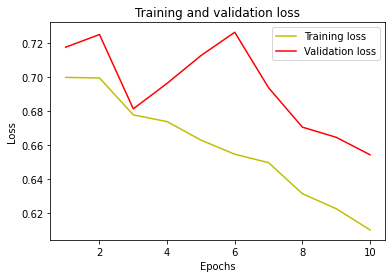

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = historial.history['loss']
val_loss = historial.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

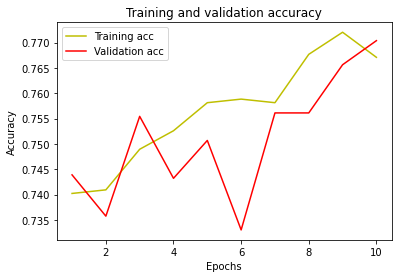

In [ ]:
acc = historial.history['acc']
val_acc = historial.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()